Copyright 2017 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# Latent Constraints: Conditional Generation from Unconditional Generative Models
### ___Jesse Engel, Matthew Hoffman, Adam Roberts___ [arXiv link](http://arxiv.org/abs/1711.05772)

___
__Abstract:__ Deep generative neural networks have proven effective at both conditional and unconditional modeling of complex data distributions.
Conditional generation enables interactive control, but creating new controls often requires expensive retraining.
In this paper, we develop a method to condition generation without retraining the model.
By post-hoc learning ___latent constraints___, value functions that identify regions in latent space that generate outputs with desired attributes, we can conditionally sample from these regions with gradient-based optimization or amortized actor functions.
Combining attribute constraints with a universal ``realism`` constraint, which enforces similarity to the data distribution, we generate realistic conditional images from an unconditional variational autoencoder.
Further, using gradient-based optimization, we demonstrate identity-preserving transformations that make
the minimal adjustment in latent space to modify the attributes of an image.
Finally, with discrete sequences of musical notes, we demonstrate zero-shot conditional generation, learning latent constraints in the absence of labeled data or a differentiable reward function.

___

![](http://download.magenta.tensorflow.org/models/latent_constraints/ipynb_figs/diagram.png =400x400 "Latent Space Diagram")
![](http://download.magenta.tensorflow.org/models/latent_constraints/ipynb_figs/cgen.png =540x500 "Conditional Generation with and without a distance penalty")

___

This notebook contains code for running experiments related to the paper. First, we load pretrained checkpoints:

  * VAE models trained on CelebA with pixelwise gaussian data liklihoods of $\mathcal{N}(\mu(z), \sigma_x=0.1)$ and $\mathcal{N}(\mu(z), \sigma_x=1)$.
  * We also provide embeddings of the training and eval set from the VAE models.
  * A generator ($G$) and discriminator ($D$) from a conditional-GAN, trained to shift samples from the prior to new points in latent space that satisfy the realism constraint ($r$) and attribute constraints ($r_{attr}$).
  * We have versions trained with no distance penalty, and also with a penalty of 1e-1.
  * A seperately trained attribute classifier in both z-space ($D_{attr}$) and pixel space ($Classifier$).

We then proceed to:
 * Demonstrate that VAE reconstructions sharpen as $\sigma_x$ lowers, at the expense of sample quality, which is compensated with latent constraints.
 * Plot conditional generation using CGANs ($D$, $G$) both with and without distance penalty.
 * Perform identity preserving transformations doing SGD in z-space wrt $D_{attr}$
 * Evaluate the accuracy of generating images with conditional attributes.

Training loops are also provided for demonstration purposes at the end of the notebook.

___

This colab notebook is self-contained and should run natively on google cloud. The code and checkpoints can be downloaded separately and run locally, which is recommended if you want to train your own model. Pretrained model checkpoints are available at [download.magenta.tensorflow.org/models/latent_constraints/latent_constraints.tar](http://download.magenta.tensorflow.org/models/latent_constraints/latent_constraints.tar).

__Tips:__ Don't forget you can navigate with the _Table of Contents_ in the left hand sidebar, and collapse all sections with (`Ctrl + Shift + ]`)




In [1]:
# This notebook requires DeepMind's sonnet library, which itself
# requires the nightly build of TensorFlow. The command below
# installs both.
# !pip install -q -U dm-sonnet==1.36 tf-nightly tfp-nightly
# !pip install gsutil

import os
import PIL

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.metrics
import sonnet as snt
# import tensorflow.compat.v1 as tf
import tensorflow_probability as tfp

# ds = tfp.distributions

# tf.disable_v2_behavior()

%matplotlib inline

2025-02-11 21:51:50.694249: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-11 21:51:50.697716: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-11 21:51:50.707680: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739290910.723754 2131630 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739290910.728770 2131630 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-11 21:51:50.745840: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
# Copy checkpoints from google cloud
# Copying 3GB, takes a minute
# !gsutil  -m cp -R gs://download.magenta.tensorflow.org/models/latent_constraints .

In [3]:
# import tensorflow as tf
import sonnet as snt

print(snt.__version__)

# !pip install uninstall tensorflow

2.0.2


# Load the Data

In [4]:
basepath = './latent_constraints/'

# Load CelebA embeddings
# VAE with x_sigma = 0.1
train_mu = np.load(basepath + 'train_mu.npy')
train_sigma = np.load(basepath + 'train_sigma.npy')
eval_mu = np.load(basepath + 'eval_mu.npy')
eval_sigma = np.load(basepath + 'eval_sigma.npy')

# VAE with x_sigma = 1.0
eval_mu_xsigma1 = np.load(basepath + 'eval_mu_xsigma1.npy')
eval_sigma_xsigma1 = np.load(basepath + 'eval_sigma_xsigma1.npy')

np.random.seed(10003)
n_train = train_mu.shape[0]
n_eval = eval_mu.shape[0]

# Load Attributes
# Only use 10 salient attributes
attr_train = np.load(basepath + 'attr_train.npy')
attr_eval = np.load(basepath + 'attr_eval.npy')
attr_test = np.load(basepath + 'attr_test.npy')

attr_mask = [4, 8, 9, 11, 15, 20, 24, 31, 35, 39]
attribute_names = [
    'Bald',
    'Black_Hair',
    'Blond_Hair',
    'Brown_Hair',
    'Eyeglasses',
    'Male',
    'No_Beard',
    'Smiling',
    'Wearing_Hat',
    'Young',
]

attr_train = attr_train[:, attr_mask]
attr_eval = attr_eval[:, attr_mask]
attr_test = attr_test[:, attr_mask]

# Define the Graph

All the functions with variables are wrapped in `sonnet` modules.

As is the ``model`` that ties them all together.

Tensors (endpoints) are accessible as attributes of the ``model``.

In [5]:
import tensorflow as tf
import sonnet as snt

# ------------------------------------------------------------
# Encoder: VAE Convolutional Encoder.
# ------------------------------------------------------------
class Encoder(snt.Module):
    def __init__(self,
                 n_latent,
                 layers=((256, 5, 2),
                         (512, 5, 2),
                         (1024, 3, 2),
                         (2048, 3, 2)),
                 name="encoder"):
        super().__init__(name=name)
        self.n_latent = n_latent
        # Create a list of convolutional layers based on the provided parameters.
        self._convs = []
        for i, (channels, kernel_size, stride) in enumerate(layers):
            self._convs.append(
                snt.Conv2D(output_channels=channels,
                           kernel_shape=kernel_size,
                           stride=stride,
                           name=f"conv_{i}")
            )
        # The final fully-connected layer projects the flattened features
        # to 2*n_latent outputs (to be split into μ and σ parameters).
        self._fc = snt.Linear(2 * n_latent, name="fc")

    def __call__(self, x):
        h = x
        for conv in self._convs:
            h = tf.nn.relu(conv(h))
        # Flatten spatial dimensions (using dynamic shape)
        h = tf.reshape(h, [tf.shape(h)[0], -1])
        pre_z = self._fc(h)
        mu = pre_z[:, :self.n_latent]
        sigma = tf.nn.softplus(pre_z[:, self.n_latent:])
        return mu, sigma


# ------------------------------------------------------------
# Decoder: VAE Convolutional Decoder.
# ------------------------------------------------------------
class Decoder(snt.Module):
    def __init__(self,
                 layers=((2048, 4, 4),
                         (1024, 3, 2),
                         (512, 3, 2),
                         (256, 5, 2),
                         (3, 5, 2)),
                 name="decoder"):
        super().__init__(name=name)
        self._layers_params = layers
        # The first layer is a fully-connected layer that “projects” the latent
        # vector to a spatial tensor.
        first_channels, first_height, first_width = layers[0]
        self._fc = snt.Linear(first_channels * first_height * first_width, name="fc")
        # Create a list of Conv2DTranspose layers for the remaining layers.
        self._deconvs = []
        for i, (channels, kernel_size, stride) in enumerate(layers[1:], start=1):
            self._deconvs.append(
                snt.Conv2DTranspose(output_channels=channels,
                                    kernel_shape=kernel_size,
                                    stride=stride,
                                    name=f"deconv_{i}")
            )
        # Save the spatial dimensions from the first layer for reshaping.
        self._first_shape = (first_height, first_width, first_channels)

    def __call__(self, x):
        # First, project and reshape.
        first_channels, first_height, first_width = self._layers_params[0]
        h = self._fc(x)
        h = tf.reshape(h, [-1, first_height, first_width, first_channels])
        # Iterate over deconvolution layers.
        # Note: For all layers except the last one, we apply a ReLU nonlinearity.
        for i, deconv in enumerate(self._deconvs, start=1):
            h = deconv(h)
            if i != len(self._layers_params) - 1:
                h = tf.nn.relu(h)
        logits = h
        return logits


# ------------------------------------------------------------
# G: CGAN Generator (maps from z-space to z-space).
# ------------------------------------------------------------
class G(snt.Module):
    def __init__(self,
                 n_latent,
                 layers=(2048,) * 4,
                 name="generator"):
        super().__init__(name=name)
        self.n_latent = n_latent
        # A linear mapping from labels to the first hidden size.
        self._label_linear = snt.Linear(layers[0], name="label_linear")
        # A sequence of hidden fully-connected layers.
        self._hidden_linears = []
        for i, size in enumerate(layers):
            self._hidden_linears.append(
                snt.Linear(size, name=f"hidden_linear_{i}")
            )
        # Final layer produces 2*n_latent outputs.
        self._out_linear = snt.Linear(2 * n_latent, name="out_linear")

    def __call__(self, z_and_labels):
        z, labels = z_and_labels
        labels = tf.cast(labels, tf.float32)
        # Concatenate the latent vector with the projected label features.
        label_proj = self._label_linear(labels)
        x = tf.concat([z, label_proj], axis=-1)
        for linear in self._hidden_linears:
            x = tf.nn.relu(linear(x))
        x = self._out_linear(x)
        dz = x[:, :self.n_latent]
        gates = tf.nn.sigmoid(x[:, self.n_latent:])
        # Compute the new latent vector as a gate–weighted combination.
        z_prime = (1 - gates) * z + gates * dz
        return z_prime


# ------------------------------------------------------------
# D: CGAN Discriminator.
# ------------------------------------------------------------
class D(snt.Module):
    def __init__(self,
                 output_size=1,
                 layers=(2048,) * 4,
                 name="D"):
        super().__init__(name=name)
        self.output_size = output_size
        # A linear mapping from labels to the first hidden size.
        self._label_linear = snt.Linear(layers[0], name="label_linear")
        self._hidden_linears = []
        for i, size in enumerate(layers):
            self._hidden_linears.append(
                snt.Linear(size, name=f"hidden_linear_{i}")
            )
        self._out_linear = snt.Linear(output_size, name="out_linear")

    def __call__(self, z_and_labels):
        z, labels = z_and_labels
        labels = tf.cast(labels, tf.float32)
        label_proj = self._label_linear(labels)
        x = tf.concat([z, label_proj], axis=-1)
        for linear in self._hidden_linears:
            x = tf.nn.relu(linear(x))
        logits = self._out_linear(x)
        return logits


# ------------------------------------------------------------
# DAttr: Attribute Classifier from z-space.
# ------------------------------------------------------------
class DAttr(snt.Module):
    def __init__(self,
                 output_size=1,
                 layers=(2048,) * 4,
                 name="DAttr"):
        super().__init__(name=name)
        self.output_size = output_size
        self._hidden_linears = []
        for i, size in enumerate(layers):
            self._hidden_linears.append(
                snt.Linear(size, name=f"hidden_linear_{i}")
            )
        self._out_linear = snt.Linear(output_size, name="out_linear")

    def __call__(self, x):
        for linear in self._hidden_linears:
            x = tf.nn.relu(linear(x))
        logits = self._out_linear(x)
        return logits


# ------------------------------------------------------------
# Classifier: Convolutional Attribute Classifier from Pixels.
# ------------------------------------------------------------
class Classifier(snt.Module):
    def __init__(self,
                 output_size,
                 layers=((256, 5, 2),
                         (256, 3, 1),
                         (512, 5, 2),
                         (512, 3, 1),
                         (1024, 3, 2),
                         (2048, 3, 2)),
                 name="classifier"):
        super().__init__(name=name)
        self.output_size = output_size
        # Create a list of convolutional layers.
        self._convs = []
        for i, (channels, kernel_size, stride) in enumerate(layers):
            self._convs.append(
                snt.Conv2D(output_channels=channels,
                           kernel_shape=kernel_size,
                           stride=stride,
                           name=f"conv_{i}")
            )
        self._out_linear = snt.Linear(output_size, name="out_linear")

    def __call__(self, x):
        h = x
        for conv in self._convs:
            h = tf.nn.relu(conv(h))
        # Flatten before applying the final linear layer.
        h = tf.reshape(h, [tf.shape(h)[0], -1])
        logits = self._out_linear(h)
        return logits


In [6]:
import tensorflow as tf
import sonnet as snt
import numpy as np
import tensorflow_probability as tfp

ds = tfp.distributions

# =============================================================================
# A Migrated Model that “glues” all components together in Sonnet v2.
# =============================================================================
class Model(snt.Module):
    def __init__(self, config, name=""):
        super().__init__(name=name)
        self.config = config

        # Constants from configuration.
        self.batch_size = config['batch_size']
        self.n_latent = config['n_latent']
        self.img_width = config['img_width']
        self.half_batch = int(self.batch_size // 2)
        self.n_labels = 10  # (fixed in your code)

        # ---------------------------------------------------------------------
        # Instantiate the submodules (which you previously defined as Sonnet
        # AbstractModules) now as Sonnet Modules.
        # ---------------------------------------------------------------------
        self.encoder = Encoder(n_latent=self.n_latent, name="encoder")
        self.decoder = Decoder(name="decoder")
        self.generator = G(n_latent=self.n_latent, name="generator")
        self.discriminator = D(output_size=1, name="d_z")
        self.d_attr = DAttr(output_size=self.n_labels, name="d_attr")
        self.classifier = Classifier(output_size=self.n_labels, name="classifier")

        # Instead of a placeholder for z_prime, create a trainable variable.
        self.z_prime = tf.Variable(
            initial_value=tf.random.normal([self.half_batch, self.n_latent]),
            trainable=True,
            name="z_prime"
        )

        # ---------------------------------------------------------------------
        # Create optimizers for the various components. (In TF2 you typically use
        # tf.keras.optimizers rather than tf.train.AdamOptimizer.)
        # ---------------------------------------------------------------------
        self.opt_vae = tf.keras.optimizers.Adam(learning_rate=3e-4)
        self.opt_d = tf.keras.optimizers.Adam(learning_rate=3e-4, beta_1=0, beta_2=0.9)
        self.opt_classifier = tf.keras.optimizers.Adam(learning_rate=3e-4)
        self.opt_g = tf.keras.optimizers.Adam(learning_rate=3e-4, beta_1=0, beta_2=0.9)
        self.opt_d_attr = tf.keras.optimizers.Adam(learning_rate=3e-4)
        self.opt_transform = tf.keras.optimizers.Adam(learning_rate=3e-4)

    @tf.function
    def __call__(self, x, labels, r, z0, transform=False, amortize=False):
        """
        Given input images `x`, one‑hot attribute labels `labels`, a real/fake
        indicator `r` (for the discriminator), and an initial latent vector `z0`,
        compute all forward–pass endpoints and losses.

        The boolean flags `transform` and `amortize` control whether a transformation
        variable is used or whether the generator is applied to z.
        """
        config = self.config
        batch_size = self.batch_size
        n_latent = self.n_latent
        half_batch = self.half_batch

        # ---------------------------------------------------------------------
        # VAE: Encode x to get parameters of q(z|x) and sample from it.
        # ---------------------------------------------------------------------
        mu, sigma = self.encoder(x)
        q_z = ds.Normal(loc=mu, scale=sigma)
        q_z_sample = q_z.sample()

        # Decide whether to use a transformed version of z:
        z = tf.cond(
            tf.convert_to_tensor(transform),
            lambda: self.z_prime,
            lambda: q_z_sample
        )

        # Optionally apply the generator (i.e. amortized transformation) to z.
        z = tf.cond(
            tf.convert_to_tensor(amortize),
            lambda: self.generator((z, labels)),
            lambda: z
        )

        # Decode z into image logits.
        logits = self.decoder(z)
        x_sigma = tf.constant(config['x_sigma'], dtype=tf.float32)
        p_x = ds.Normal(loc=tf.nn.sigmoid(logits), scale=x_sigma)
        x_mean = p_x.mean()

        # Reconstruction loss.
        recons = tf.reduce_sum(p_x.log_prob(x), axis=[1, 2, 3])
        mean_recons = tf.reduce_mean(recons)

        # ---------------------------------------------------------------------
        # KL divergence between q(z|x) and the prior p(z) ~ N(0,1).
        # ---------------------------------------------------------------------
        p_z = ds.Normal(loc=0., scale=1.)
        KL_qp = ds.kl_divergence(q_z, p_z)
        KL = tf.reduce_sum(KL_qp, axis=-1)
        mean_KL = tf.reduce_mean(KL)

        beta = tf.constant(config['beta'], dtype=tf.float32)
        vae_loss = -mean_recons + mean_KL * beta

        # ---------------------------------------------------------------------
        # Discriminator on z-space.
        # ---------------------------------------------------------------------
        d_logits = self.discriminator((z, labels))
        r_pred = tf.nn.sigmoid(d_logits)
        # (Here we use TF2’s lower-level loss; you could also use a Keras loss.)
        d_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=r, logits=d_logits)
        d_loss = tf.reduce_mean(d_loss)

        # ---------------------------------------------------------------------
        # Gradient penalty for the discriminator.
        # ---------------------------------------------------------------------
        real_data = z[:half_batch]
        fake_data = z[half_batch:batch_size]
        alpha = tf.random.uniform(shape=[half_batch, n_latent], minval=0., maxval=1.)
        differences = fake_data - real_data
        interpolates = real_data + alpha * differences

        # Compute gradients of discriminator’s prediction on interpolated points.
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolates)
            interp_pred = self.discriminator((interpolates, labels[:half_batch]))
        gradients = gp_tape.gradient(interp_pred, interpolates)
        slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=1) + 1e-10)
        gradient_penalty = tf.reduce_mean((slopes - 1.)**2)

        lambda_weight = tf.constant(config['lambda_weight'], dtype=tf.float32)
        d_loss_training = d_loss + lambda_weight * gradient_penalty

        # ---------------------------------------------------------------------
        # Discriminator attribute classification (in z-space).
        # ---------------------------------------------------------------------
        attr_weights = tf.constant(np.ones([1, self.n_labels], dtype=np.float32))
        logits_attr = self.d_attr(z)
        pred_attr = tf.nn.sigmoid(logits_attr)
        d_loss_attr = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.cast(labels, tf.float32), logits=logits_attr)
        d_loss_attr = tf.reduce_mean(d_loss_attr * attr_weights)

        # ---------------------------------------------------------------------
        # Optimization transformation (using a variable or optimizing via SGD).
        # ---------------------------------------------------------------------
        transform_r_weight = tf.constant(1.0, dtype=tf.float32)
        loss_transform = transform_r_weight * tf.reduce_mean(d_loss)
        transform_attr_weight = tf.constant(0.0, dtype=tf.float32)
        loss_transform += transform_attr_weight * d_loss_attr
        transform_penalty_weight = tf.constant(0.0, dtype=tf.float32)
        z_sigma_mean = tf.constant(np.ones([1, n_latent], dtype=np.float32))
        transform_penalty = tf.math.log(1.0 + tf.square(self.z_prime - z0))
        transform_penalty = transform_penalty * tf.pow(z_sigma_mean, -2)
        loss_transform += tf.reduce_mean(transform_penalty_weight * transform_penalty)

        # ---------------------------------------------------------------------
        # Amortized transformation (Generator loss).
        # ---------------------------------------------------------------------
        g_loss = -tf.math.log(tf.clip_by_value(r_pred, 1e-15, 1 - 1e-15))
        g_loss = tf.reduce_mean(g_loss)
        g_penalty_weight = tf.constant(0.0, dtype=tf.float32)
        g_penalty = tf.math.log(1.0 + tf.square(z - q_z_sample))
        g_penalty = g_penalty * tf.pow(z_sigma_mean, -2)
        g_penalty = tf.reduce_mean(g_penalty)
        g_loss += g_penalty_weight * g_penalty

        # ---------------------------------------------------------------------
        # Classifier (from pixels) for attribute prediction.
        # ---------------------------------------------------------------------
        logits_classifier = self.classifier(x)
        pred_classifier = tf.nn.sigmoid(logits_classifier)
        classifier_loss = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.cast(labels, tf.float32), logits=logits_classifier)
        classifier_loss = tf.reduce_mean(classifier_loss)

        # ---------------------------------------------------------------------
        # Pack losses and endpoints in dictionaries.
        # ---------------------------------------------------------------------
        losses = {
            "vae_loss": vae_loss,
            "d_loss": d_loss_training,
            "d_loss_attr": d_loss_attr,
            "g_loss": g_loss,
            "classifier_loss": classifier_loss,
            "loss_transform": loss_transform,
            "mean_recons": mean_recons,
            "mean_KL": mean_KL,
        }

        outputs = {
            "x_mean": x_mean,
            "r_pred": r_pred,
            "pred_attr": pred_attr,
            "pred_classifier": pred_classifier,
            "z": z,
            "q_z_sample": q_z_sample,
            "mu": mu,
            "sigma": sigma,
        }

        return losses, outputs

    # =========================================================================
    # Below are example training–step methods that use TF2’s GradientTape.
    # In TF2 it is common to write separate functions for each training update.
    # =========================================================================

    @tf.function
    def train_vae(self, x, labels, r, z0, transform=False, amortize=False):
        with tf.GradientTape() as tape:
            losses, _ = self(x, labels, r, z0, transform, amortize)
            loss = losses["vae_loss"]
        # Collect the trainable variables of the encoder and decoder.
        vars_vae = self.encoder.trainable_variables + self.decoder.trainable_variables
        grads = tape.gradient(loss, vars_vae)
        self.opt_vae.apply_gradients(zip(grads, vars_vae))
        return loss

    @tf.function
    def train_d(self, x, labels, r, z0, transform=False, amortize=False):
        with tf.GradientTape() as tape:
            losses, _ = self(x, labels, r, z0, transform, amortize)
            loss = losses["d_loss"]
        vars_d = self.discriminator.trainable_variables
        grads = tape.gradient(loss, vars_d)
        self.opt_d.apply_gradients(zip(grads, vars_d))
        return loss

    @tf.function
    def train_classifier(self, x, labels, r, z0, transform=False, amortize=False):
        with tf.GradientTape() as tape:
            losses, _ = self(x, labels, r, z0, transform, amortize)
            loss = losses["classifier_loss"]
        vars_classifier = self.classifier.trainable_variables
        grads = tape.gradient(loss, vars_classifier)
        self.opt_classifier.apply_gradients(zip(grads, vars_classifier))
        return loss

    @tf.function
    def train_g(self, x, labels, r, z0, transform=False, amortize=False):
        with tf.GradientTape() as tape:
            losses, _ = self(x, labels, r, z0, transform, amortize)
            loss = losses["g_loss"]
        vars_g = self.generator.trainable_variables
        grads = tape.gradient(loss, vars_g)
        self.opt_g.apply_gradients(zip(grads, vars_g))
        return loss

    @tf.function
    def train_d_attr(self, x, labels, r, z0, transform=False, amortize=False):
        with tf.GradientTape() as tape:
            losses, _ = self(x, labels, r, z0, transform, amortize)
            loss = losses["d_loss_attr"]
        vars_d_attr = self.d_attr.trainable_variables
        grads = tape.gradient(loss, vars_d_attr)
        self.opt_d_attr.apply_gradients(zip(grads, vars_d_attr))
        return loss

    @tf.function
    def train_transform(self, x, labels, r, z0, transform=False, amortize=False):
        with tf.GradientTape() as tape:
            losses, _ = self(x, labels, r, z0, transform, amortize)
            loss = losses["loss_transform"]
        # Here we update only the transform variable, z_prime.
        grads = tape.gradient(loss, [self.z_prime])
        self.opt_transform.apply_gradients(zip(grads, [self.z_prime]))
        return loss

# Load all models

In [7]:
config = {
    'n_latent': 1024,
    'img_width': 64,
    'crop_width': 64,
    # Optimization parameters
    'batch_size': 128,
    'beta': 1.0,
    'x_sigma': 0.1,
    'lambda_weight': 10.0,
    'penalty_weight': 0.0,
}

In [8]:
# Instantiate your model with the configuration.
model = Model(config, name="model")

# Create dummy inputs to build the model:
# Dummy images (grayscale, so 1 channel); adjust channels if needed.
x_dummy = tf.zeros([config['batch_size'], config['img_width'], config['img_width'], 1],
                   dtype=tf.float32)

# Dummy labels (one-hot vectors with 10 classes).
labels_dummy = tf.zeros([config['batch_size'], 10], dtype=tf.float32)

# Dummy real/fake indicator for the discriminator.
# Here we use ones, but in practice these would be 1.0 (real) or 0.0 (fake) labels.
r_dummy = tf.ones([config['batch_size'], 1], dtype=tf.float32)

# Dummy initial latent vector z0 for the transform penalty.
# Note: z0 should have shape [half_batch, n_latent].
z0_dummy = tf.zeros([config['batch_size'] // 2, config['n_latent']], dtype=tf.float32)

# Call the model with the dummy inputs to build it.
# The last two boolean flags (transform, amortize) are optional.
losses, outputs = model(x_dummy, labels_dummy, r_dummy, z0_dummy, transform=False, amortize=False)

# You can now inspect the losses and outputs.
print("Losses:")
for key, value in losses.items():
    print(f"  {key}: {value}")

print("\nOutputs:")
for key, value in outputs.items():
    print(f"  {key}: {value}")

W0000 00:00:1739290917.911694 2131630 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
W0000 00:00:1739290922.489622 2131630 loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: model/cond_1/branch_executed/_29


Losses:
  vae_loss: 136479.921875
  d_loss: 9.237424850463867
  d_loss_attr: 0.6777356863021851
  g_loss: 0.6903768181800842
  classifier_loss: 0.6931475400924683
  loss_transform: 0.6903768181800842
  mean_recons: -136370.625
  mean_KL: 109.30120086669922

Outputs:
  x_mean: [[[[0.5000773  0.49994752 0.5002111 ]
   [0.50011283 0.49977297 0.50008285]
   [0.5001812  0.50007117 0.49992153]
   ...
   [0.50032115 0.49985898 0.5004793 ]
   [0.4999717  0.49939844 0.5005005 ]
   [0.50022405 0.5001075  0.49996603]]

  [[0.5000326  0.49990797 0.5000581 ]
   [0.4996693  0.49997738 0.500101  ]
   [0.50023407 0.4993227  0.49981558]
   ...
   [0.49834734 0.5007098  0.49998337]
   [0.4998623  0.4991247  0.50128645]
   [0.49956885 0.4991873  0.50034297]]

  [[0.50022435 0.49975523 0.50014675]
   [0.49960622 0.50058895 0.49993768]
   [0.50047505 0.4998651  0.5002613 ]
   ...
   [0.5006707  0.49898183 0.4997807 ]
   [0.4996098  0.50009316 0.50063014]
   [0.5004039  0.50055194 0.5009862 ]]

  ...

  [[0

In [9]:
import os
import tensorflow as tf

# Define the checkpoint path.
ckpt_path = os.path.join(basepath, 'vae_best_celeba_0_crop128_beta1.ckpt')

# Create a checkpoint object that tracks the encoder and decoder.
vae_checkpoint = tf.train.Checkpoint(encoder=model.encoder, decoder=model.decoder)

# Restore the checkpoint.
# If the checkpoint contains exactly the same variables, you can use assert_consumed().
# If not (for example, if only a subset is saved), then use expect_partial() to avoid errors.
status = vae_checkpoint.restore(ckpt_path)
status.expect_partial()  # or .assert_consumed() if a full match is expected

# Now your VAE (encoder and decoder) variables have been restored.


Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.


In [10]:
import os
import tensorflow as tf

# Define the checkpoint path for the discriminator.
ckpt_path = os.path.join(basepath, 'D_d_2_conditional_penalty1e-1_399000.ckpt')

# Create a checkpoint object tracking the discriminator.
d_checkpoint = tf.train.Checkpoint(discriminator=model.discriminator)

# Restore the checkpoint.
status = d_checkpoint.restore(ckpt_path)
# If the checkpoint does not contain exactly all of the tracked variables,
# you can use expect_partial() to avoid an error:
status.expect_partial()  # or, if you're sure everything should match: status.assert_consumed()


In [33]:
import os
import tensorflow as tf

# ============================
# Load Generator (G)
# ============================
ckpt_path = os.path.join(basepath, 'G_d_2_conditional_penalty1e-1_399000.ckpt')
g_checkpoint = tf.train.Checkpoint(generator=model.generator)
status = g_checkpoint.restore(ckpt_path)
# If the checkpoint only contains a subset of the variables, use expect_partial().
status.expect_partial()  # or use status.assert_consumed() if an exact match is expected

# ============================
# Load Discriminator for Attributes (D_attr)
# ============================
ckpt_path = os.path.join(basepath, 'D_attr_best_d_attr_0.ckpt')
d_attr_checkpoint = tf.train.Checkpoint(d_attr=model.d_attr)
status = d_attr_checkpoint.restore(ckpt_path)
status.expect_partial()

# ============================
# Load Classifier
# ============================
ckpt_path = os.path.join(basepath, 'classifier_best_classifier_0.ckpt')
classifier_checkpoint = tf.train.Checkpoint(classifier=model.classifier)
status = classifier_checkpoint.restore(ckpt_path)
status.expect_partial()


# GENERATE PLOTS

In [34]:
def im(x):
  plt.imshow(np.maximum(0, np.minimum(1, x)), interpolation='none')
  plt.xticks([])
  plt.yticks([])

def batch_image(b, max_images=64, rows=None, cols=None):
  """Turn a batch of images into a single image mosaic."""
  mb = min(b.shape[0], max_images)
  if rows is None:
    rows = int(np.ceil(np.sqrt(mb)))
    cols = rows
  diff = rows * cols - mb
  b = np.vstack([b[:mb], np.zeros([diff, b.shape[1], b.shape[2], b.shape[3]])])
  tmp = b.reshape(-1, cols * b.shape[1], b.shape[2], b.shape[3])
  img = np.hstack(tmp[i] for i in range(rows))
  return img

In [35]:
# A list of attributes from which to condition generation
# Each list element corresponds to a different fully-speciffied condition

cond_attr_list = [
    [
        (0, 'Bald'),
        (0, 'Black_Hair'),
        (1, 'Blond_Hair'),
        (0, 'Brown_Hair'),
        (0, 'Eyeglasses'),
        (0, 'Male'),
        (1, 'No_Beard'),
        (1, 'Smiling'),
        (0, 'Wearing_Hat'),
        (1, 'Young'),
    ],
    [
        (0, 'Bald'),
        (0, 'Black_Hair'),
        (0, 'Blond_Hair'),
        (1, 'Brown_Hair'),
        (0, 'Eyeglasses'),
        (0, 'Male'),
        (1, 'No_Beard'),
        (1, 'Smiling'),
        (0, 'Wearing_Hat'),
        (1, 'Young'),
    ],
    [
        (0, 'Bald'),
        (1, 'Black_Hair'),
        (0, 'Blond_Hair'),
        (0, 'Brown_Hair'),
        (0, 'Eyeglasses'),
        (0, 'Male'),
        (1, 'No_Beard'),
        (1, 'Smiling'),
        (0, 'Wearing_Hat'),
        (1, 'Young'),
    ],
    [
        (0, 'Bald'),
        (1, 'Black_Hair'),
        (0, 'Blond_Hair'),
        (0, 'Brown_Hair'),
        (0, 'Eyeglasses'),
        (1, 'Male'),
        (1, 'No_Beard'),
        (1, 'Smiling'),
        (0, 'Wearing_Hat'),
        (1, 'Young'),
    ],
    [
        (0, 'Bald'),
        (1, 'Black_Hair'),
        (0, 'Blond_Hair'),
        (0, 'Brown_Hair'),
        (0, 'Eyeglasses'),
        (1, 'Male'),
        (0, 'No_Beard'),
        (1, 'Smiling'),
        (0, 'Wearing_Hat'),
        (1, 'Young'),
    ],
    [
        (0, 'Bald'),
        (1, 'Black_Hair'),
        (0, 'Blond_Hair'),
        (0, 'Brown_Hair'),
        (1, 'Eyeglasses'),
        (1, 'Male'),
        (0, 'No_Beard'),
        (1, 'Smiling'),
        (0, 'Wearing_Hat'),
        (1, 'Young'),
    ],
    [
        (1, 'Bald'),
        (0, 'Black_Hair'),
        (0, 'Blond_Hair'),
        (0, 'Brown_Hair'),
        (0, 'Eyeglasses'),
        (1, 'Male'),
        (0, 'No_Beard'),
        (1, 'Smiling'),
        (0, 'Wearing_Hat'),
        (1, 'Young'),
    ],
    [
        (1, 'Bald'),
        (0, 'Black_Hair'),
        (0, 'Blond_Hair'),
        (0, 'Brown_Hair'),
        (0, 'Eyeglasses'),
        (1, 'Male'),
        (0, 'No_Beard'),
        (0, 'Smiling'),
        (0, 'Wearing_Hat'),
        (0, 'Young'),
    ],
]

cond_attrs = [
    np.tile(np.array([[attr for attr, _ in attrs]], dtype=np.int32), (model.batch_size, 1))
    for attrs in cond_attr_list
]

# VAE Reconstructions

In [36]:
import os
import tensorflow as tf

# ------------------------------
# Load Discriminator (D)
# ------------------------------
ckpt_path_d = os.path.join(basepath, 'D_d_2_conditional_399000.ckpt')
d_checkpoint = tf.train.Checkpoint(discriminator=model.discriminator)
status_d = d_checkpoint.restore(ckpt_path_d)
# Use expect_partial() if the checkpoint only contains a subset of variables.
status_d.expect_partial()  # Alternatively, use status_d.assert_consumed() if full match is expected.

# ------------------------------
# Load Generator (G)
# ------------------------------
ckpt_path_g = os.path.join(basepath, 'G_d_2_conditional_399000.ckpt')
g_checkpoint = tf.train.Checkpoint(generator=model.generator)
status_g = g_checkpoint.restore(ckpt_path_g)
status_g.expect_partial()  # Alternatively, use status_g.assert_consumed() if full match is expected.


In [37]:
import os
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
ds = tfp.distributions

# Assume that:
#   - config is a dictionary (with keys like 'batch_size', 'img_width', 'x_sigma', etc.)
#   - model is an instance of your Model (already created with Model(config, name="model"))
#   - attr_eval, eval_mu_xsigma1, eval_sigma_xsigma1, eval_mu, eval_sigma are defined numpy arrays.

# =============================================================================
# 1. Build the model (if not already built) with a dummy forward pass.
# =============================================================================


# Run a dummy forward pass so that all variables are created.
_ = model(x_dummy, labels_dummy, r_dummy, z0_dummy, transform=False, amortize=False)

# =============================================================================
# 2. Define helper functions for decoding a latent vector.
# =============================================================================
def decode_latent(z):
    """Run the decoder (VAE) on a given latent code z."""
    logits = model.decoder(z)
    # Use the configured standard deviation.
    x_sigma = tf.constant(config['x_sigma'], dtype=tf.float32)
    p_x = ds.Normal(loc=tf.nn.sigmoid(logits), scale=x_sigma)
    return p_x.mean()

def decode_amortized(z, labels):
    """Run the generator to transform z, then decode via the decoder."""
    # Pass z (with labels) through the generator (amortized transformation).
    z_transformed = model.generator((z, labels))
    logits = model.decoder(z_transformed)
    x_sigma = tf.constant(config['x_sigma'], dtype=tf.float32)
    p_x = ds.Normal(loc=tf.nn.sigmoid(logits), scale=x_sigma)
    return p_x.mean()

# =============================================================================
# 3. Prepare latent codes and labels.
# =============================================================================
# For example, generate 9 random latent vectors.
z_prior = np.random.randn(9, model.n_latent).astype(np.float32)
# Use the first 9 attribute vectors.
labels_input = attr_eval[:9]

# =============================================================================
# 4. Restore the "blurry" VAE checkpoint and run inference.
# =============================================================================
ckpt_path_blurry = os.path.join(basepath, 'vae_best_celeba_0_crop128_beta1_xsigma1.ckpt')
vae_checkpoint = tf.train.Checkpoint(encoder=model.encoder, decoder=model.decoder)
status = vae_checkpoint.restore(ckpt_path_blurry)
status.expect_partial()  # Use expect_partial() if only a subset of variables is saved.

# Prepare a latent code computed from blurry evaluation data.
z_eval_blurry = (eval_mu_xsigma1[:9] +
                 eval_sigma_xsigma1[:9] * np.random.randn(9, model.n_latent)).astype(np.float32)

# Instead of feeding internal tensors, directly call the helper to get reconstructions.
b_eval_recon_blurry = decode_latent(z_eval_blurry)
b_samples_blurry = decode_latent(z_prior)

# =============================================================================
# 5. Restore the "sharp" VAE checkpoint and run inference.
# =============================================================================
ckpt_path_sharp = os.path.join(basepath, 'vae_best_celeba_0_crop128_beta1.ckpt')
status = vae_checkpoint.restore(ckpt_path_sharp)
status.expect_partial()

z_eval_sharp = (eval_mu[:9] +
                eval_sigma[:9] * np.random.randn(9, model.n_latent)).astype(np.float32)
b_eval_recon_sharp = decode_latent(z_eval_sharp)
b_samples_sharp = decode_latent(z_prior)

# For refined samples, use the amortized transformation.
b_samples_refined = decode_amortized(z_prior, labels_input)

# =============================================================================
# 6. (Optional) Convert tensors to numpy arrays for further processing or visualization.
# =============================================================================
b_eval_recon_blurry_np = b_eval_recon_blurry.numpy()
b_samples_blurry_np = b_samples_blurry.numpy()
b_eval_recon_sharp_np = b_eval_recon_sharp.numpy()
b_samples_sharp_np = b_samples_sharp.numpy()
b_samples_refined_np = b_samples_refined.numpy()

# Now you can, for example, display or save the images contained in these arrays.


(9, 64, 64, 3)


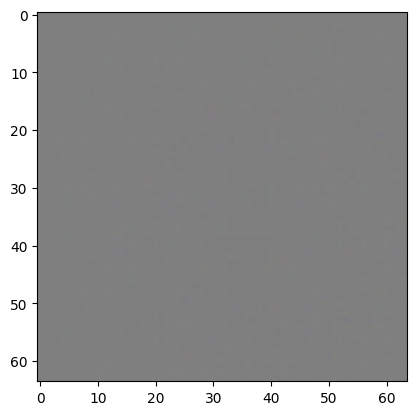

In [38]:
print(b_eval_recon_blurry_np.shape)
# Suppose b_eval_recon_blurry_np[0] has shape (3, 64, 64)
img = np.transpose(b_eval_recon_blurry_np[0], (0, 1, 2))  # New shape: (64, 64, 3)
plt.imshow(img)
plt.show()


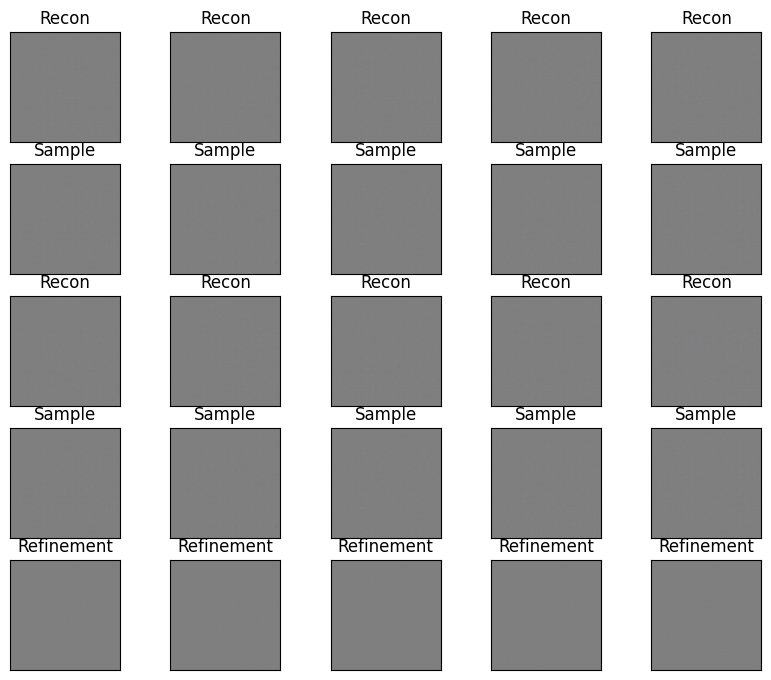

In [39]:
# Visualize Reconstructions
tot = 6
row = 5
plt.figure(figsize=[10, 10])
for i in range(row):
  plt.subplot(tot, row, 1 +  i+5*1)
  im(b_eval_recon_blurry[i])
  plt.title('Recon')
  plt.subplot(tot, row, 1 +  i+5*2)
  im(b_samples_blurry[i])
  plt.title('Sample')
  plt.subplot(tot, row, 1 +  i+5*3)
  im(b_eval_recon_sharp[i])
  plt.title('Recon')
  plt.subplot(tot, row, 1 + i+5*4)
  im(b_samples_sharp[i])
  plt.title('Sample')
  plt.subplot(tot, row, 1 + i+5*5)
  im(b_samples_refined[i])
  plt.title('Refinement')

# Conditional Generation

## Z-Penalty = 0.0

In [ ]:
# Load D
ckpt = os.path.join(basepath, 'D_d_2_conditional_399000.ckpt')
m.d_saver.restore(sess, ckpt)
# Load G
ckpt = os.path.join(basepath, 'G_d_2_conditional_399000.ckpt')
m.g_saver.restore(sess, ckpt)

INFO:tensorflow:Restoring parameters from /content/latent_constraints/D_d_2_conditional_399000.ckpt
INFO:tensorflow:Restoring parameters from /content/latent_constraints/G_d_2_conditional_399000.ckpt


In [ ]:
# Compute the Conditional Samples
z_original = sess.run(m.prior_sample)
z_new = [z_original]
b_new = [sess.run(m.x_mean, {m.z:z_original})]

for cond_attr in cond_attrs:
  z_new.append(sess.run(m.z, {m.q_z_sample: z_original, m.amortize:True, m.labels:cond_attr}))
  b_new.append(sess.run(m.x_mean, {m.z:z_new[-1]}))

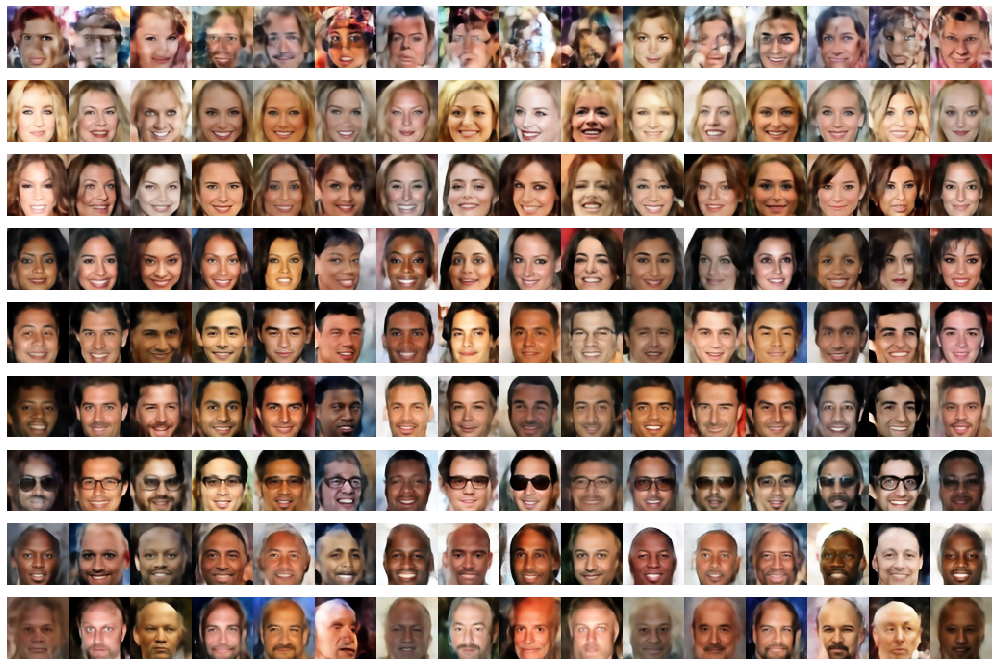

In [ ]:
# Plot them
idxs = range(10)
plt.figure(figsize=(12, 14))
n_b = len(b_new)
tot = 6
barr = np.array(b_new)
barr = np.swapaxes(barr, 0, 1)
barr = barr[idxs, :, :, :, :]

plt.figure(figsize=(18, 12))
n_b = len(b_new)
tot = 16
for i, b in enumerate(b_new):
  plt.subplot(n_b, 1, i + 1)
  im(batch_image(b, max_images=tot, rows=tot, cols=1))

## Z-Penalty = 0.1

In [ ]:
# Load D
ckpt = os.path.join(basepath, 'D_d_2_conditional_penalty1e-1_399000.ckpt')
m.d_saver.restore(sess, ckpt)
# Load G
ckpt = os.path.join(basepath, 'G_d_2_conditional_penalty1e-1_399000.ckpt')
m.g_saver.restore(sess, ckpt)

In [ ]:
# Compute the Conditional Samples
z_original = sess.run(m.prior_sample)
z_new = [z_original]
b_new = [sess.run(m.x_mean, {m.z:z_original})]

for cond_attr in cond_attrs:
  z_new.append(sess.run(m.z, {m.q_z_sample: z_original, m.amortize:True, m.labels:cond_attr}))
  b_new.append(sess.run(m.x_mean, {m.z:z_new[-1]}))

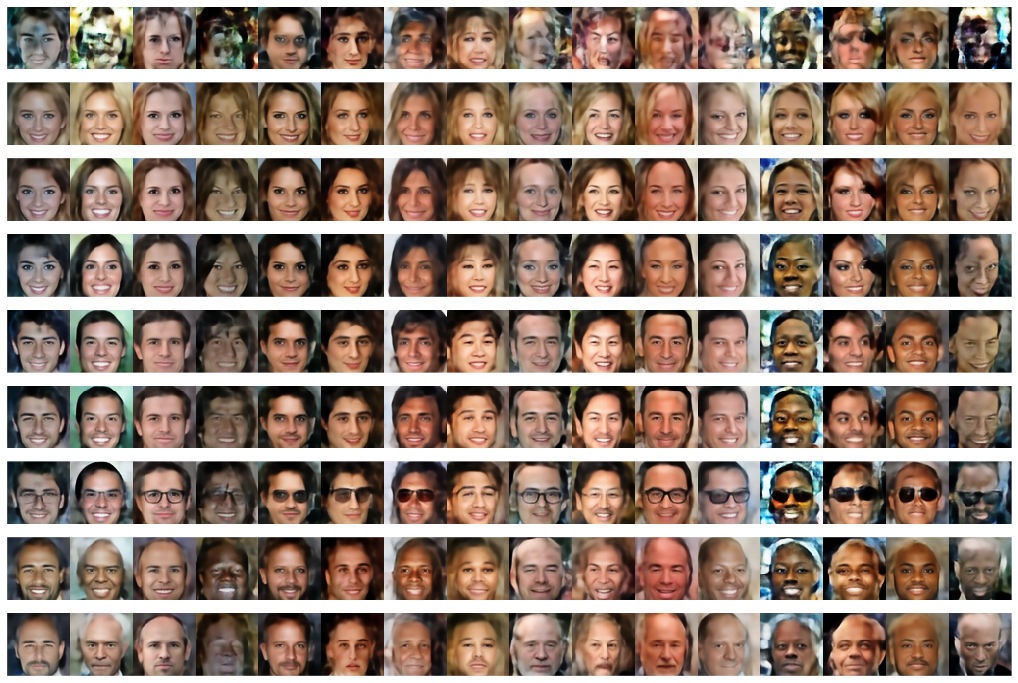

In [ ]:
# Plot them
idxs = range(10)
plt.figure(figsize=(12, 14))
n_b = len(b_new)
tot = 6
barr = np.array(b_new)
barr = np.swapaxes(barr, 0, 1)
barr = barr[idxs, :, :, :, :]

plt.figure(figsize=(18, 12))
n_b = len(b_new)
tot = 16
for i, b in enumerate(b_new):
  plt.subplot(n_b, 1, i + 1)
  im(batch_image(b, max_images=tot, rows=tot, cols=1))

# Identity Preserving Transformations

In [ ]:
# Load D
ckpt = os.path.join(basepath, 'D_d_2_conditional_penalty1e-1_399000.ckpt')
m.d_saver.restore(sess, ckpt)
# Load G
ckpt = os.path.join(basepath, 'G_d_2_conditional_penalty1e-1_399000.ckpt')
m.g_saver.restore(sess, ckpt)

In [ ]:
def transform(z_original,
              labels,
              z0=None,
              lr=1e-1,
              n_opt=100,
              penalty_weight=0.0,
              r_weight=1.0,
              attr_weight=1.0,
              attr_weights=np.ones([1, m.n_labels]),
              r_threshold = 0.9,
              attr_threshold = 0.9,
              adaptive=False,
             ):

  if z0 is None:
    z0 = z_original
  _ = sess.run(tf.assign(m.z_prime, z_original))
  z_new = np.zeros([m.half_batch, m.n_latent])
  i_threshold = np.zeros([m.half_batch])
  z_trace = []
  for i in range(n_opt):
    res = sess.run([m.train_transform,
                    m.loss_transform,
                    m.transform_penalty,
                    m.z_prime,
                    m.r_pred,
                    m.pred_attr],
                   {m.z0: z0,
                    m.r: np.ones([m.half_batch, 1]),
                    m.labels: labels,
                    m.transform: True,
                    m.transform_lr: lr,
                    m.transform_penalty_weight: penalty_weight,
                    m.transform_r_weight: r_weight,
                    m.transform_attr_weight: attr_weight,
                    m.attr_weights: attr_weights,
                    m.x: np.zeros([m.half_batch, m.img_width, m.img_width, 3])
                   })

    z_prime = res[3]
    z_trace.append(z_prime)
    pred_r = res[-2]
    pred_attr = res[-1]
    attr_acc = 1.0 - np.mean(attr_weights * np.abs(labels - pred_attr), axis=1)
    transform_penalty = np.mean(res[2])
    check_idx = np.where(i_threshold == 0)[0]
    if len(check_idx) == 0:
      break
    for idx in check_idx:
      if pred_r[idx] > r_threshold and attr_acc[idx] > attr_threshold:
        z_new[idx] = z_prime[idx]
        i_threshold[idx] = i
    if adaptive:
      r_weight = 1 - np.mean(pred_r)
      attr_weight = 1 - np.mean(attr_acc)

    if i % 100 == 1:
      print('Step %d, NotConverged: %d, Loss: %0.3e, Penalty: %0.3f, '
            'r: %0.3f, r_min: %0.3f, '
            'attr: %0.3f, attr_min:%0.3f, ' % (
                i,
                len(check_idx),
                res[1],
                transform_penalty,
                np.mean(pred_r),
                np.min(pred_r),
                np.mean(attr_acc),
                np.min(attr_acc),
           ))


  check_idx = np.where(i_threshold == 0)[0]
  print('%d did not converge' % len(check_idx))
  for idx in check_idx:
    z_new[idx] = z_prime[idx]
  return z_new, i_threshold, z_trace


In [ ]:
# BETA1 TRANSFORMATION
z_original = (eval_mu[:m.half_batch] +
              eval_sigma[:m.half_batch] * np.random.randn(m.half_batch, m.n_latent))
z = z_original

label_list = (
    (1, 1, 1e-2, 1e-3, 0.05),
    (2, 1, 1e-2, 1e-3, 0.05),
    (3, 1, 1e-2, 1e-3, 0.05),
    (4, 1, 1e-2, 1e-5, 0.05),
    (5, 0, 1e-2, 1e-3, 0.05),
    (5, 1, 1e-2, 1e-4, 0.05),
    (6, 0, 5e-3, 1e-4, 0.005),
    (7, 0, 1e-2, 1e-3, 0.05),
    (7, 1, 1e-2, 1e-3, 0.05),
    (9, 0, 3e-2, 1e-4, 0.01),
    (9, 1, 3e-2, 1e-4, 0.01)
)
z_list = [z_original]
b_list = [sess.run(m.x_mean, {m.z: z_original})]


for attr, value, lr, r_thresh, r_weight in label_list:
  print('Label: %d, Value: %d' % (attr, value))
  attr_weights=np.zeros([1, m.n_labels])
  labels = attr_eval[:m.half_batch].copy()
  labels[:, attr] = value
  attr_weights[:, attr] = 1

  z, i_threshold, z_trace = transform(
      z_original,
      labels,
      lr=lr,
      n_opt=300,
      r_weight=r_weight,
      attr_weight=1.0,
      attr_weights=attr_weights,
      r_threshold=0.3,
      attr_threshold=(1 - r_thresh),
  )
  z_list.append(z)
  b_list.append(sess.run(m.x_mean, {m.z: z}))

Label: 1, Value: 1
Step 1, NotConverged: 64, Loss: 4.044e+00, Penalty: 0.000, r: 0.360, r_min: 0.043, attr: 0.927, attr_min:0.900, 
Step 101, NotConverged: 26, Loss: 4.887e-02, Penalty: 0.059, r: 0.654, r_min: 0.100, attr: 0.998, attr_min:0.983, 
Step 201, NotConverged: 15, Loss: 2.059e-02, Penalty: 0.077, r: 0.801, r_min: 0.291, attr: 0.999, attr_min:0.993, 
7 did not converge
Label: 2, Value: 1
Step 1, NotConverged: 64, Loss: 6.228e+00, Penalty: 0.000, r: 0.339, r_min: 0.009, attr: 0.918, attr_min:0.900, 
Step 101, NotConverged: 4, Loss: 2.578e-02, Penalty: 0.124, r: 0.676, r_min: 0.373, attr: 0.999, attr_min:0.992, 
Step 201, NotConverged: 1, Loss: 1.244e-02, Penalty: 0.131, r: 0.828, r_min: 0.699, attr: 1.000, attr_min:0.999, 
0 did not converge
Label: 3, Value: 1
Step 1, NotConverged: 64, Loss: 3.173e+00, Penalty: 0.000, r: 0.387, r_min: 0.048, attr: 0.922, attr_min:0.900, 
Step 101, NotConverged: 37, Loss: 3.778e-02, Penalty: 0.087, r: 0.721, r_min: 0.235, attr: 0.998, attr_min:0

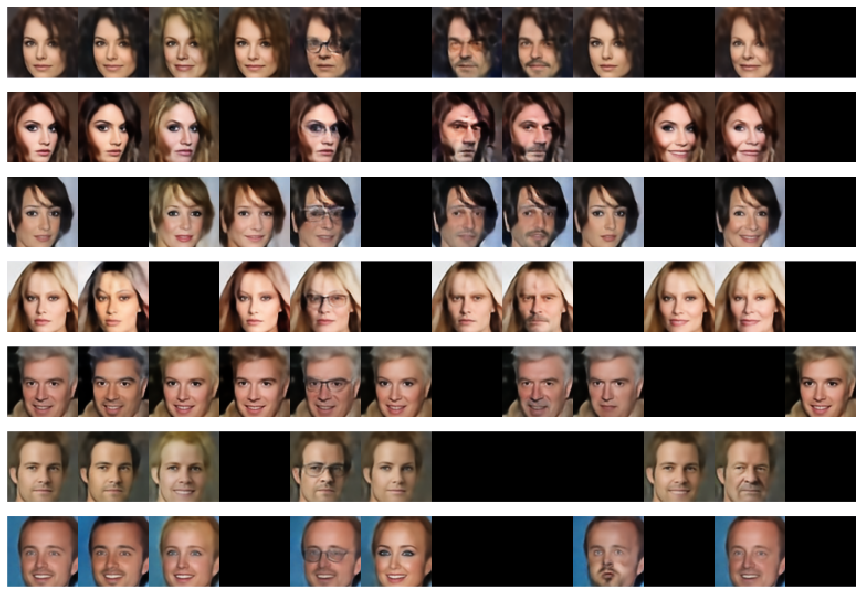

In [ ]:
labels = attr_eval[:m.half_batch].copy()
idxs = (0, 2, 5, 10, 7, 13,  3,)
labels = labels[idxs, :]

plt.figure(figsize=(24, 18))
n_b = len(b_list)
tot = 6
barr = np.array(b_list)
barr = np.swapaxes(barr, 0, 1)
barr = barr[idxs, :, :, :, :]
for i, b in enumerate(barr):
  for j, (k, v, _, _, _) in enumerate(label_list):
    if labels[i, k] == v:
      barr[i, j+1] = 0.

for i, b in enumerate(barr):
  plt.subplot(12, 1, i + 1)
  im(batch_image(b, max_images=n_b, rows=n_b, cols=1))

# Attribute Classification Accuracy


In [ ]:
# Load D
ckpt = os.path.join(basepath, 'D_d_2_conditional_penalty1e-1_399000.ckpt')
m.d_saver.restore(sess, ckpt)
# Load G
ckpt = os.path.join(basepath, 'G_d_2_conditional_penalty1e-1_399000.ckpt')
m.g_saver.restore(sess, ckpt)

## Original Images

In [ ]:
tf.train.AdamOptimizer()
batch_size = 256
# Prediction Accuracy
train_pred = []
eval_pred = []
test_pred = []

for i in range(n_train / 10 /batch_size):
  start = (i * batch_size)
  end = start + batch_size
  batch_images = train_data[start:end]

  start = i * batch_size
  end = start + batch_size
  res = sess.run([m.pred_classifier], {m.x: batch_images})
  train_pred.append(res[0])
train_pred = np.vstack(train_pred)

for i in range(n_eval/batch_size):
  start = (i * batch_size)
  end = start + batch_size
  batch_images = eval_data[start:end]

  res = sess.run([m.pred_classifier], {m.x: batch_images})
  eval_pred.append(res[0])
eval_pred = np.vstack(eval_pred)

train_acc = (train_pred > 0.5) == attr_train[:train_pred.shape[0]]
eval_acc = (eval_pred > 0.5) == attr_eval[:eval_pred.shape[0]]

print("Train Accuracy: %.4f" % (np.mean(train_acc) * 100))
print("Eval Accuracy: %.4f" % (np.mean(eval_acc) * 100))

Train Accuracy: 94.3607
Eval Accuracy: 93.5628


In [ ]:
y_true = attr_eval[:eval_pred.shape[0]]
y_pred = eval_pred >= 0.5

prec, recall, f1, support = sklearn.metrics.classification.precision_recall_fscore_support(y_true, y_pred, )
report = sklearn.metrics.classification_report(y_true, y_pred, digits=3, target_names=attribute_names)
print(report)


             precision    recall  f1-score   support

       Bald      0.735     0.556     0.633       410
 Black_Hair      0.823     0.703     0.758      4111
 Blond_Hair      0.839     0.815     0.827      3035
 Brown_Hair      0.751     0.519     0.614      4760
 Eyeglasses      0.955     0.907     0.930      1368
       Male      0.980     0.965     0.973      8394
   No_Beard      0.948     0.978     0.963     16211
    Smiling      0.928     0.909     0.919      9519
Wearing_Hat      0.871     0.845     0.858       930
      Young      0.872     0.950     0.909     14719

avg / total      0.901     0.893     0.895     63457



## Conditional Generation

In [ ]:
# Prediction Accuracy
train_pred = []
eval_pred = []
test_pred = []

for i in range(n_eval/batch_size):
  start = (i * batch_size)
  end = start + batch_size
  labels = attr_eval[start:end]
  batch_z = np.random.randn(labels.shape[0], config["n_latent"])
  xtmp = np.zeros([labels.shape[0], img_width*img_width])
  xsamp, z_prime = sess.run([m.x_mean, m.z],
                  {m.q_z_sample: batch_z,
                   m.amortize:True,
                   m.labels:labels})
  res = sess.run([m.pred_classifier], {m.x: xsamp})
  eval_pred.append(res[0])
eval_pred = np.vstack(eval_pred)

eval_acc = (eval_pred > 0.5) == attr_eval[:eval_pred.shape[0]]

eval_softmax = eval_pred.argmax(axis=-1) == attr_eval[:eval_pred.shape[0]].argmax(axis=-1)

print("Eval Accuracy: %.4f" % (np.mean(eval_acc) * 100))

Eval Accuracy: 94.3121


In [ ]:
y_true = attr_eval[:eval_pred.shape[0]]
y_pred = eval_pred >= 0.5

prec, recall, f1, support = sklearn.metrics.classification.precision_recall_fscore_support(y_true, y_pred, )
report = sklearn.metrics.classification_report(y_true, y_pred, digits=3, target_names=attribute_names)
print(report)


             precision    recall  f1-score   support

       Bald      0.800     0.390     0.525       410
 Black_Hair      0.865     0.448     0.590      4111
 Blond_Hair      0.803     0.744     0.772      3035
 Brown_Hair      0.720     0.428     0.537      4760
 Eyeglasses      0.961     0.796     0.871      1368
       Male      0.977     0.938     0.957      8394
   No_Beard      0.941     0.990     0.965     16211
    Smiling      0.925     0.948     0.936      9519
Wearing_Hat      0.953     0.653     0.775       930
      Young      0.887     0.940     0.913     14719

avg / total      0.903     0.863     0.874     63457



# TRAINING MODELS

This code is for demonstration purposes.

Training of the VAE and D and G can take about a day on a TitanX GPU.

To train models from scratch, you will need to download the entire [CelebA dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to a base directory (assumed as `~/Desktop/CelebA/`). The steps for preprocessing the data are provided below.

(img_align_celeba/, list_attr_celeba.txt, list_eval_partition.txt)

In [ ]:
# Running Average
running_N = 100
running_N_eval = 10
rmean = lambda data: np.mean(data[-running_N:])
rmeane = lambda data: np.mean(data[-running_N_eval:])
batch_size = 256

## Prepare the Data (Crop and Pad)

In [ ]:
basepath = os.path.expanduser('~/Desktop/CelebA/')
save_path = basepath

In [ ]:
partition = np.loadtxt(basepath + 'list_eval_partition.txt', usecols=(1,))
train_mask = (partition == 0)
eval_mask = (partition == 1)
test_mask = (partition == 2)

print("Train: %d, Validation: %d, Test: %d, Total: %d" % (train_mask.sum(), eval_mask.sum(), test_mask.sum(), partition.shape[0]))

Train: 162770, Validation: 19867, Test: 19962, Total: 202599


In [ ]:
attributes = pd.read_table(basepath + 'list_attr_celeba.txt', skiprows=1, delim_whitespace=True, usecols=range(1, 41))
attribute_names = attributes.columns.values
attribute_values = attributes.values

In [ ]:
attr_train = attribute_values[train_mask]
attr_eval = attribute_values[eval_mask]
attr_test = attribute_values[test_mask]

attr_train[attr_train == -1] = 0
attr_eval[attr_eval == -1] = 0
attr_test[attr_test == -1] = 0

np.save(basepath + 'attr_train.npy', attr_train)
np.save(basepath + 'attr_eval.npy', attr_eval)
np.save(basepath + 'attr_test.npy', attr_test)

In [ ]:
def pil_crop_downsample(x, width, out_width):
  half_shape = tuple((i - width) / 2 for i in x.size)
  x = x.crop([half_shape[0], half_shape[1], half_shape[0] + width, half_shape[1] + width])
  return x.resize([out_width, out_width], resample=PIL.Image.ANTIALIAS)

def load_and_adjust_file(filename, width, outwidth):
  img = PIL.Image.open(filename)
  img = pil_crop_downsample(img, width, outwidth)
  img = np.array(img, np.float32) / 255.
  return img

In [ ]:
# CELEBA images are (218 x 178) originally
filenames = np.sort(glob(basepath + 'img_align_celeba/*.jpg'))

crop_width = 128
img_width = 64
postfix = '_crop_%d_res_%d.npy' % (crop_width, img_width)

n_files = len(filenames)
all_data = np.zeros([n_files, img_width, img_width, 3], np.float32)
for i, fname in enumerate(filenames):
  all_data[i, :, :] = load_and_adjust_file(fname, crop_width, img_width)
  if i % 10000 == 0:
    print('%.2f percent done' % (float(i)/n_files * 100.0))
train_data = all_data[train_mask]
eval_data = all_data[eval_mask]
test_data = all_data[test_mask]
np.save(basepath + 'train' + postfix, train_data)
np.save(basepath + 'eval' + postfix, eval_data)
np.save(basepath + 'test' + postfix, test_data)


0.00 percent done
4.94 percent done
9.87 percent done
14.81 percent done
19.74 percent done
24.68 percent done
29.62 percent done
34.55 percent done
39.49 percent done
44.42 percent done
49.36 percent done
54.29 percent done
59.23 percent done
64.17 percent done
69.10 percent done
74.04 percent done
78.97 percent done
83.91 percent done
88.85 percent done
93.78 percent done
98.72 percent done


# Train the VAE

In [ ]:
sess.run(tf.variables_initializer(var_list=m.vae_vars))

# Train the VAE
results = []
results_eval = []

traces = {'i': [],
          'i_eval': [],
          'loss': [],
          'loss_eval': [],
          'recons': [],
          'recons_eval': [],
          'kl': [],
          'kl_eval': []}

n_iters = 200000
vae_lr_ = np.logspace(np.log10(3e-4), np.log10(1e-6), n_iters)

for i in range(n_iters):
  start = (i * batch_size) % n_train
  end = start + batch_size
  batch = train_data[start:end]

  res = sess.run([m.train_vae,
                  m.vae_loss,
                  m.mean_recons,
                  m.mean_KL],
                 {m.x: batch,
                  m.vae_lr: vae_lr_[i],
                  m.amortize: False,
                  m.labels: attr_train[start:end]})

  traces['loss'].append(res[1])
  traces['recons'].append(res[2])
  traces['kl'].append(res[3])
  traces['i'].append(i)

  if i % 10 == 0:
    start = (i * batch_size) % n_eval
    end = start + batch_size
    batch = eval_data[start:end]
    res_eval = sess.run([m.vae_loss, m.mean_recons, m.mean_KL],
                        {m.x: batch, m.labels: attr_eval[start:end]})
    traces['loss_eval'].append(res_eval[0])
    traces['recons_eval'].append(res_eval[1])
    traces['kl_eval'].append(res_eval[2])
    traces['i_eval'].append(i)

    print('Step %5d \t TRAIN \t Loss: %0.3f, Recon: %0.3f, KL: %0.3f '
          '\t EVAL \t  Loss: %0.3f, Recon: %0.3f, KL: %0.3f' % (i,
                                                                rmean(traces['loss']),
                                                                rmean(traces['recons']),
                                                                rmean(traces['kl']),
                                                                rmeane(traces['loss_eval']),
                                                                rmeane(traces['recons_eval']),
                                                                rmeane(traces['kl_eval']) ))

In [ ]:
plt.figure(figsize=(18,6))

plt.subplot(131)
plt.plot(traces['i'], traces['loss'])
plt.plot(traces['i_eval'], traces['loss_eval'])
plt.title('Loss')
# plt.ylim(30, 100)

plt.subplot(132)
plt.plot(traces['i'], traces['recons'])
plt.plot(traces['i_eval'], traces['recons_eval'])
plt.title('Recons')
# plt.ylim(-100, -30)

plt.subplot(133)
plt.plot(traces['i'], traces['kl'])
plt.plot(traces['i_eval'], traces['kl_eval'])
plt.title('KL')
# plt.ylim(10, 100)


# Train D and G jointly

In [ ]:
# Precompute means and vars
train_mu = []
train_sigma = []
n_batches = int(np.ceil(float(n_train) / batch_size))
for i in range(n_batches):
  if i % 1000 == 0:
    print('%.1f Done' % (float(i) / n_train * batch_size * 100))
  start = i * batch_size
  end = start + batch_size
  res = sess.run([m.mu, m.sigma], {m.x: train_data[start:end]})
  train_mu.append(res[0])
  train_sigma.append(res[1])
train_mu = np.vstack(train_mu)
train_sigma = np.vstack(train_sigma)
sigma_mean = train_sigma.mean(0, keepdims=True)
print(train_mu.shape, train_sigma.shape, train_data.shape)

0.0 Done
(162770, 1024) (162770, 1024) (162770, 64, 64, 3)


In [ ]:
# Precompute means and vars
eval_mu = []
eval_sigma = []
n_batches = int(np.ceil(float(n_eval) / batch_size))
for i in range(n_batches):
  if i % 1000 == 0:
    print('%.1f Done' % (float(i) / n_eval * batch_size * 100))
  start = i * batch_size
  end = start + batch_size
  res = sess.run([m.mu, m.sigma], {m.x: eval_data[start:end]})
  eval_mu.append(res[0])
  eval_sigma.append(res[1])
eval_mu = np.vstack(eval_mu)
eval_sigma = np.vstack(eval_sigma)
sigma_mean_eval = eval_sigma.mean(0, keepdims=True)
print(eval_mu.shape, eval_sigma.shape, eval_data.shape)

0.0 Done
(19867, 1024) (19867, 1024) (19867, 64, 64, 3)


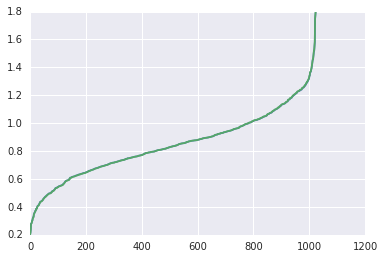

In [ ]:
plt.plot(np.sort(sigma_mean.flatten()))
plt.plot(np.sort(sigma_mean_eval.flatten()))

In [ ]:
# With eval loss, looking for overfitting
sess.run(tf.variables_initializer(var_list=m.d_vars))
sess.run(tf.variables_initializer(var_list=m.g_vars))

# Declare hyperparameters
results_D = []
results_G = []
traces = {'i': [],
          'i_pred': [],
          'D': [],
          'G': [],
          'G_real': [],
          'g_penalty': [],
          'pred_train': [],
          'pred_eval': [],
          'pred_prior': [],
          'pred_gen': [],
          'z_dist_eval': [],
          'attr_loss': [],
          'attr_acc': [],
         }


n_iters = 200000
d_lr_ = np.logspace(-4, -4, n_iters)
g_lr_ = np.logspace(-4, -4, n_iters)

g_penalty_weight_ = 0.1
lambda_weight_ = 10
z_sigma_mean_ = sigma_mean

percentage_prior_fake = 0.1
N_between_update_G = 10
N_between_eval = 100

n_train = train_mu.shape[0]
n_eval = eval_mu.shape[0]

# Training Loop
for i in range(n_iters):
  start = (i * batch_size/2) % n_train
  end = start + batch_size/2
  fake_start = np.random.choice(np.arange(n_train - batch_size/2))
  fake_end = fake_start + batch_size/2

  real_img = train_data[start:end]
  n_batch = real_img.shape[0]
  if n_batch == batch_size/2 and start != fake_start:
    # Compare real vs. fake
    fake_z_prior = np.random.randn(batch_size/2, n_latent)
    real_attr = attr_train[start:end].astype(np.int32)
    fake_attr = attr_train[fake_start:fake_end].astype(np.int32)
    real_z = train_mu[start:end] + train_sigma[start:end] * np.random.randn(batch_size/2, n_latent)



    if np.random.rand(1) < percentage_prior_fake:
      # Use Prior for fake_samples
      all_z = np.vstack([real_z, fake_z_prior, real_z])
    else:
      # Use Generator to make fake_samples
      fake_z_gen = sess.run(m.z, {m.q_z_sample: fake_z_prior,
                                  m.amortize:True,
                                  m.labels: real_attr,})
      all_z = np.vstack([real_z, fake_z_gen, real_z])
    all_attr = np.vstack([real_attr, real_attr, fake_attr])


    # Train Discriminator
    real_r = np.ones([batch_size/2, 1])
    fake_r = np.zeros([batch_size/2, 1])
    all_r = np.concatenate([real_r, fake_r, fake_r])
    res_d = sess.run([m.train_d, m.d_loss], {m.z: all_z,
                                         m.r: all_r,
                                         m.d_lr: d_lr_[i],
                                         m.lambda_weight: lambda_weight_,
                                         m.labels: all_attr,})

    # Train Generator
    if i % N_between_update_G == 0:
      if g_penalty_weight_ > 0:
        # Train on real data
        res_g_real = sess.run([m.train_g, m.g_loss, m.g_penalty],
                              {m.q_z_sample: real_z,
                               m.amortize: True,
                               m.g_penalty_weight: g_penalty_weight_,
                               m.z_sigma_mean: z_sigma_mean_,
                               m.g_lr: g_lr_[i],
                               m.labels: real_attr,})
        traces['G_real'].append(res_g_real[1])

      # Train on generated data
      res_g = sess.run([m.train_g, m.g_loss, m.g_penalty],
                       {m.q_z_sample: fake_z_prior,
                        m.amortize: True,
                        m.g_penalty_weight: g_penalty_weight_,
                        m.z_sigma_mean: z_sigma_mean_,
                        m.g_lr: g_lr_[i],
                        m.labels: real_attr,})



    traces['i'].append(i)
    traces['D'].append(res_d[1])
    traces['G'].append(res_g[1])
    traces['g_penalty'].append(res_g[2])

    if i % N_between_eval == 0:
      eval_start = np.random.choice(np.arange(n_eval - batch_size/2))
      eval_end = eval_start + batch_size/2
      real_attr_eval = attr_eval[eval_start:eval_end].astype(np.int32)
      real_z_eval = eval_mu[eval_start:eval_end] + eval_sigma[eval_start:eval_end] * np.random.randn(batch_size/2, n_latent)
      z_eval_gen = sess.run(m.z, {m.q_z_sample: real_z_eval,
                                  m.amortize:True,
                                  m.labels: real_attr,})
      fake_z_gen = sess.run(m.z, {m.q_z_sample: fake_z_prior,
                                  m.amortize:True,
                                  m.labels: real_attr,})

      pred_train_ = np.mean(sess.run([m.r_pred], {m.z: real_z, m.labels: real_attr}))
      pred_eval_ = np.mean(sess.run([m.r_pred], {m.z: real_z_eval, m.labels: real_attr_eval}))
      pred_prior_ = np.mean(sess.run([m.r_pred], {m.z: fake_z_prior, m.labels: real_attr}))
      pred_gen_ = np.mean(sess.run([m.r_pred], {m.z: fake_z_gen, m.labels: real_attr}))

      traces['i_pred'].append(i)
      traces['pred_train'].append(pred_train_)
      traces['pred_eval'].append(pred_eval_)
      traces['pred_prior'].append(pred_prior_)
      traces['pred_gen'].append(pred_gen_)
      traces['z_dist_eval'].append(np.mean(((z_eval_gen - real_z_eval)/z_sigma_mean_)**2))
      print('PRED Step %d, \t TRAIN: %.2e \t EVAL: %.2e \t PRIOR: %.2e \t GEN: %.2e ' % (i,
                                                                                         rmeanp(traces['pred_train']),
                                                                                         rmeanp(traces['pred_eval']),
                                                                                         rmeanp(traces['pred_prior']),
                                                                                         rmeanp(traces['pred_gen'])))


In [ ]:
plt.figure(figsize=(18,12))

plt.subplot(4, 1, 1)
plt.plot(traces['i_pred'], traces['pred_train'], label='train')
plt.plot(traces['i_pred'], traces['pred_eval'], label='eval')
plt.plot(traces['i_pred'], traces['pred_prior'], label='prior')
plt.plot(traces['i_pred'], traces['pred_gen'], label='gen')
plt.ylabel('Predictions')
plt.legend(loc='upper right')

plt.subplot(4, 1, 2)
plt.plot(traces['i'], traces['G'])
plt.ylabel('G Loss')

plt.subplot(4, 1, 3)
# plt.semilogy(traces['i'], traces['D'])
plt.plot(traces['i'], traces['D'])
plt.ylabel('D Loss')

plt.subplot(4, 1, 4)
plt.semilogy(traces['i_pred'], traces['z_dist_eval'])
plt.ylabel('Weighted Z Distance Eval')

# Train Classifier

In [ ]:
sess.run(tf.variables_initializer(var_list=m.classifier_vars))
# Train the Classifier
results = []
results_eval = []

running_N = 100
running_loss = 1
running_loss_eval = 1

classifier_lr_ = 3e-4

# Train
for i in range(40000):
  start = (i * batch_size) % n_train
  end = start + batch_size
  batch_images = train_data[start:end]
  batch_labels = attr_train[start:end]

  res = sess.run([m.train_classifier,
                  m.classifier_loss],
                 {m.x: batch_images,
                  m.labels: batch_labels.astype(np.int32),
                  m.classifier_lr: classifier_lr_})
  running_loss += (res[1] - running_loss) / running_N
  if i % 10 == 1:
    start = (i * batch_size) % n_eval
    end = start + batch_size
    eval_images = eval_data[start:end]
    eval_labels = attr_eval[start:end]
    res_eval = sess.run([m.classifier_loss],
                        {m.x: eval_images,
                         m.labels: eval_labels.astype(np.int32)})
    running_loss_eval += (res_eval[0] - running_loss_eval) / (running_N / 10)

    results.append([i] + res[1:])
    results_eval.append([i] + res_eval[0:])

  if i % 10 == 1:
    print('Step %d, \t TRAIN \t Loss: %0.3f \t EVAL \t Loss: %0.3f' % (i, running_loss, running_loss_eval))

In [ ]:
plot_train = np.array(results).T
plot_eval = np.array(results_eval).T
plt.figure(figsize=(18,6))
plt.plot(plot_train[0],plot_train[1])
plt.plot(plot_eval[0],plot_eval[1])
plt.ylim(1e-1, 1)
plt.title('Loss')

In [ ]:
# Prediction Accuracy
train_pred = []
eval_pred = []
test_pred = []

for i in range(n_train / 10 /batch_size):
  start = (i * batch_size)
  end = start + batch_size
  batch_images = train_data[start:end]

  start = i * batch_size
  end = start + batch_size
  res = sess.run([m.pred_classifier], {m.x: batch_images})
  train_pred.append(res[0])
train_pred = np.vstack(train_pred)

for i in range(n_eval/batch_size):
  start = (i * batch_size)
  end = start + batch_size
  batch_images = eval_data[start:end]

  res = sess.run([m.pred_classifier], {m.x: batch_images})
  eval_pred.append(res[0])
eval_pred = np.vstack(eval_pred)

train_acc = (train_pred > 0.5) == attr_train[:train_pred.shape[0]]
eval_acc = (eval_pred > 0.5) == attr_eval[:eval_pred.shape[0]]

print("Train Accuracy: %.4f" % (np.mean(train_acc) * 100))
print("Eval Accuracy: %.4f" % (np.mean(eval_acc) * 100))

In [ ]:
y_true = attr_eval[:eval_pred.shape[0]]
y_pred = eval_pred >= 0.5

prec, recall, f1, support = sklearn.metrics.classification.precision_recall_fscore_support(y_true, y_pred, )
report = sklearn.metrics.classification_report(y_true, y_pred, digits=2, target_names=attribute_names)
print(report)


# Train Attribute Classifier (D_attr) in z space

In [ ]:
# Train the Discriminator
sess.run(tf.variables_initializer(var_list=m.d_attr_vars))
traces = {"i": [],
          "i_eval": [],
          "D_loss": [],
          "D_loss_eval": [],
          "accuracy": [],
         }
running_N = 800
running_N_eval = 80

n_iters = 10000
d_attr_lr_ = np.logspace(-4, -4, n_iters)

for i in range(n_iters):
  start = (i * batch_size/2) % n_train
  end = min(start + batch_size/2, n_train)
  batch = train_mu[start:end] + train_sigma[start:end] * np.random.randn(end-start, n_latent)
  if batch.shape[0] == batch_size/2:
    labels = attr_train[start:end]

    # Train
    res = sess.run([m.train_d_attr, m.d_loss_attr],
                   {m.z: batch,
                    m.labels: labels,
                    m.d_attr_lr: d_attr_lr_[i],})

    traces['i'].append(i)
    traces['D_loss'].append(res[1])

  if i % 10 == 1:
    start = (i * batch_size/2) % n_eval
    end = min(start + batch_size/2, n_eval)
    batch = eval_mu[start:end] + eval_sigma[start:end] * np.random.randn(end-start, n_latent)
    if batch.shape[0] == batch_size/2:
      labels = attr_eval[start:end]

      res_eval = sess.run([m.d_loss_attr, m.pred_attr],
                          {m.z: batch,
                           m.labels: labels,})

      y_true = labels
      y_pred = (res_eval[1] > 0.5)
      accuracy = np.mean(y_true == y_pred)

      traces['i_eval'].append(i)
      traces['D_loss_eval'].append(res_eval[0])
      traces['accuracy'].append(accuracy)


  if i % 100 == 0:
    print('Step %d, \t TRAIN \t Loss: %0.3f \t EVAL \t Loss: %0.3f \t Accuracy: %0.3f' % (i,
                                                                       np.mean(traces['D_loss'][-running_N_eval:]),
                                                                       np.mean(traces['D_loss_eval'][-running_N_eval:]),
                                                                       np.mean(traces['accuracy'][-running_N_eval:]),
                                                                       ))

In [ ]:
plt.figure(figsize=(18,18))
plt.subplot(3, 1, 1)
plt.semilogy(traces['i'], traces['D_loss'], label='train')
plt.semilogy(traces['i_eval'], traces['D_loss_eval'], label='eval')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.subplot(3, 1, 2)
plt.plot(traces['i_eval'], traces['accuracy'], label="eval")
plt.ylabel('Prediction Accuracy')
plt.legend(loc='upper right')

In [ ]:
# Prediction Accuracy
train_pred = []
eval_pred = []
test_pred = []

for i in range(n_train / 10 /batch_size):
  start = (i * batch_size)
  end = start + batch_size
  batch_images = train_data[start:end]

  start = i * batch_size
  end = start + batch_size
  res = sess.run([m.pred_attr], {m.x: batch_images,
                                 m.labels: attr_train[start:end]})
  train_pred.append(res[0])
train_pred = np.vstack(train_pred)

for i in range(n_eval/batch_size):
  start = (i * batch_size)
  end = start + batch_size
  batch_images = eval_data[start:end]

  res = sess.run([m.pred_attr], {m.x: batch_images,
                                 m.labels: attr_eval[start:end]})
  eval_pred.append(res[0])
eval_pred = np.vstack(eval_pred)

train_acc = (train_pred > 0.5) == attr_train[:train_pred.shape[0]]
eval_acc = (eval_pred > 0.5) == attr_eval[:eval_pred.shape[0]]

print("Train Accuracy: %.4f" % (np.mean(train_acc) * 100))
print("Eval Accuracy: %.4f" % (np.mean(eval_acc) * 100))


In [ ]:
y_true = attr_eval[:eval_pred.shape[0]]
y_pred = eval_pred >= 0.5

prec, recall, f1, support = sklearn.metrics.classification.precision_recall_fscore_support(y_true, y_pred, )
report = sklearn.metrics.classification_report(y_true, y_pred, digits=2, target_names=attribute_names)
print(report)
